# Plot Embeddings for Rating Prediction

## Goal
Test whether movie plot/overview text can improve our rating prediction model.

## Strategy
1. Load TMDb data (has plot overviews)
2. Merge with IMDb data (has ratings)
3. Create embeddings from **overview text only** (not combined with other fields)
4. Apply PCA to reduce 384 dims to manageable number
5. Combine with existing IMDb features
6. Retrain model and compare R² against baseline (0.31)

## Baseline
- Current model: RandomForest with 31 IMDb features
- R² = 0.31, MAE = 0.85 rating points

## Setup

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# For embeddings
from sentence_transformers import SentenceTransformer

# For PCA and modeling
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error

import sys
import os
# Add project root to path so we can import floportop
sys.path.append(os.path.abspath(os.path.join(os.path.dirname('__file__'), '..')))
from floportop.preprocessing import VALID_GENRES

# Paths
DATA_DIR = Path('../data')
MODELS_DIR = Path('../models')

print("Setup complete!")

Setup complete!


## Load Pre-saved Data

Loading the cleaned TMDb features and IMDb data from previous steps.

In [2]:
# Load cleaned TMDb features
tmdb_features = pd.read_csv(DATA_DIR / 'tmdb_features.csv')
print(f"TMDb features: {len(tmdb_features):,} movies")

# Load IMDb data
imdb = pd.read_csv(DATA_DIR / 'movies_clean.csv')
print(f"IMDb data: {len(imdb):,} movies")

TMDb features: 43,995 movies


IMDb data: 298,616 movies


## Task 3: Merge TMDb with IMDb Data

In [3]:
# Merge TMDb features with IMDb data
merged = imdb.merge(
    tmdb_features[['imdbId', 'overview', 'budget', 'revenue', 'director_names']],
    left_on='tconst',
    right_on='imdbId',
    how='inner'
)

print(f"Merged dataset: {len(merged):,} movies")
print(f"\nColumns: {merged.columns.tolist()}")
merged.head()

Merged dataset: 37,905 movies

Columns: ['tconst', 'primaryTitle', 'originalTitle', 'isAdult', 'startYear', 'runtimeMinutes', 'genres', 'averageRating', 'numVotes', 'imdbId', 'overview', 'budget', 'revenue', 'director_names']


,tconst,primaryTitle,originalTitle,isAdult,startYear,runtimeMinutes,genres,averageRating,numVotes,imdbId,overview,budget,revenue,director_names
0,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906.0,70,"Action,Adventure,Biography",6.0,1046,tt0000574,Just as Fritz Lang’s Metropolis (1927) is test...,0,0.0,Charles Tait
1,tt0002101,Cleopatra,Cleopatra,0,1912.0,100,"Drama,History",5.1,663,tt0002101,The fabled queen of Egypt's affair with Roman ...,0,0.0,Charles L. Gaskill
2,tt0002130,Dante's Inferno,L'inferno,0,1911.0,71,"Adventure,Drama,Fantasy",7.1,4024,tt0002130,Loosely adapted from Dante's Divine Comedy and...,0,0.0,"Giuseppe de Liguoro, Francesco Bertolini, Adol..."
3,tt0002461,The Life and Death of King Richard III,Richard III,0,1912.0,55,Drama,5.7,349,tt0002461,Shakespeare's tragedy of the hump-backed Duke ...,0,0.0,"André Calmettes, James Keane"
4,tt0002844,Fantômas: In the Shadow of the Guillotine,Fantômas I: À l'ombre de la guillotine,0,1913.0,54,"Crime,Drama",6.9,2701,tt0002844,"For the arch-criminal Fantômas, no crime is to...",0,0.0,Louis Feuillade


In [4]:
# Quick sanity check
print("Merged data summary:")
print(f"  - Total movies: {len(merged):,}")
print(f"  - Rating range: {merged['averageRating'].min():.1f} - {merged['averageRating'].max():.1f}")
print(f"  - Year range: {merged['startYear'].min():.0f} - {merged['startYear'].max():.0f}")
print(f"  - Overview lengths: {merged['overview'].str.len().min()} - {merged['overview'].str.len().max()} chars")
print(f"  - Has budget: {(merged['budget'] > 0).sum():,} ({(merged['budget'] > 0).sum()/len(merged)*100:.1f}%)")

Merged data summary:
  - Total movies: 37,905
  - Rating range: 1.2 - 9.3
  - Year range: 1906 - 2022
  - Overview lengths: 50 - 1000 chars
  - Has budget: 8,394 (22.1%)


## Task 4: Generate Embeddings from Overview Text

In [5]:
# Load the sentence transformer model
model = SentenceTransformer('all-MiniLM-L6-v2')
print(f"Model loaded: all-MiniLM-L6-v2")
print(f"Embedding dimension: 384")

Model loaded: all-MiniLM-L6-v2
Embedding dimension: 384


In [6]:
# Generate embeddings (this takes 3-5 minutes)
print(f"Generating embeddings for {len(merged):,} movie overviews...")
print("This may take 3-5 minutes...\n")

overviews_list = merged['overview'].tolist()

embeddings = model.encode(
    overviews_list,
    batch_size=64,
    show_progress_bar=True,
    normalize_embeddings=True
)

embeddings = np.array(embeddings, dtype='float32')
print(f"\nEmbeddings shape: {embeddings.shape}")

Generating embeddings for 37,905 movie overviews...
This may take 3-5 minutes...



Batches:   0%|          | 0/593 [00:00<?, ?it/s]


Embeddings shape: (37905, 384)


In [7]:
# Save embeddings to avoid recomputing
np.save(DATA_DIR / 'plot_embeddings.npy', embeddings)
merged.to_csv(DATA_DIR / 'merged_imdb_tmdb.csv', index=False)
print(f"Saved embeddings to data/plot_embeddings.npy ({embeddings.nbytes / 1e6:.1f} MB)")
print(f"Saved merged data to data/merged_imdb_tmdb.csv")

Saved embeddings to data/plot_embeddings.npy (58.2 MB)
Saved merged data to data/merged_imdb_tmdb.csv


## Task 5: Apply PCA to Reduce Embedding Dimensions

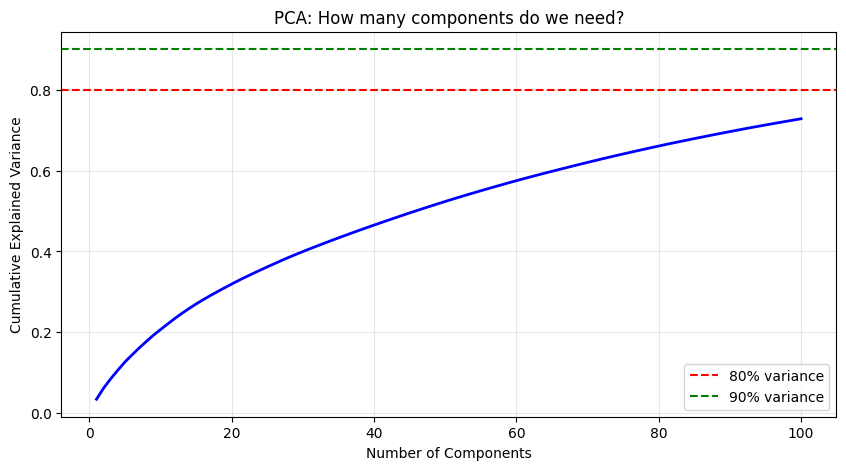

70% variance explained by 92 components
80% variance not reached (max 72.8%)
90% variance not reached (max 72.8%)
95% variance not reached (max 72.8%)


In [8]:
# See how much variance is explained by different numbers of components
pca_full = PCA(n_components=100)
pca_full.fit(embeddings)

cumvar = np.cumsum(pca_full.explained_variance_ratio_)

plt.figure(figsize=(10, 5))
plt.plot(range(1, 101), cumvar, 'b-', linewidth=2)
plt.axhline(y=0.80, color='r', linestyle='--', label='80% variance')
plt.axhline(y=0.90, color='g', linestyle='--', label='90% variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA: How many components do we need?')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

for threshold in [0.70, 0.80, 0.90, 0.95]:
    if cumvar[-1] < threshold:
        print(f"{threshold*100:.0f}% variance not reached (max {cumvar[-1]*100:.1f}%)")
    else:
        n = np.argmax(cumvar >= threshold) + 1
        print(f"{threshold*100:.0f}% variance explained by {n} components")

In [9]:
# Apply PCA with chosen number of components
N_COMPONENTS = 20

pca = PCA(n_components=N_COMPONENTS)
embeddings_pca = pca.fit_transform(embeddings)

print(f"PCA reduction: {embeddings.shape[1]} -> {embeddings_pca.shape[1]} dimensions")
print(f"Variance explained: {pca.explained_variance_ratio_.sum()*100:.1f}%")

PCA reduction: 384 -> 20 dimensions
Variance explained: 31.9%


## Task 6: Combine PCA Features with Existing IMDb Features

In [10]:
# Create PCA feature columns
pca_columns = [f'plot_pca_{i}' for i in range(N_COMPONENTS)]
pca_df = pd.DataFrame(embeddings_pca, columns=pca_columns, index=merged.index)

# Add PCA features to merged data
merged_with_pca = pd.concat([merged, pca_df], axis=1)

print(f"Added {N_COMPONENTS} PCA features")
print(f"Total columns: {len(merged_with_pca.columns)}")

Added 20 PCA features
Total columns: 34


In [11]:
# Feature engineering
CURRENT_YEAR = 2026

merged_with_pca['movie_age'] = CURRENT_YEAR - merged_with_pca['startYear']
merged_with_pca['decade'] = (merged_with_pca['startYear'] // 10 * 10).astype('Int64')
merged_with_pca['log_numVotes'] = np.log1p(merged_with_pca['numVotes'])
merged_with_pca['log_budget'] = np.log1p(merged_with_pca['budget'])
merged_with_pca['has_budget'] = (merged_with_pca['budget'] > 0).astype(int)
merged_with_pca['genre_count'] = merged_with_pca['genres'].str.split(',').str.len()

# Add Genre features
for genre in VALID_GENRES:
    merged_with_pca[f'Genre_{genre}'] = merged_with_pca['genres'].str.contains(genre, regex=False).astype(int)

print("Feature engineering complete")

Feature engineering complete

## Task 7: Retrain Model and Evaluate Improvement

In [12]:
# Define feature sets
genre_features = [f'Genre_{g}' for g in VALID_GENRES]
base_features = ['isAdult', 'movie_age', 'decade', 'log_numVotes', 'genre_count'] + genre_features
plot_features = pca_columns
budget_features = ['log_budget', 'has_budget']
all_features = base_features + plot_features + budget_features

print(f"Base features: {len(base_features)}")
print(f"Plot PCA features: {len(plot_features)}")
print(f"Budget features: {len(budget_features)}")
print(f"Total features: {len(all_features)}")

Base features: 27
Plot PCA features: 20
Budget features: 2
Total features: 49


In [13]:
# Prepare data
df_model = merged_with_pca.dropna(subset=['startYear'] + all_features)

y = df_model['averageRating']
X_base = df_model[base_features]
X_with_plot = df_model[base_features + plot_features]
X_all = df_model[all_features]

# Train/test split
X_base_train, X_base_test, y_train, y_test = train_test_split(X_base, y, test_size=0.3, random_state=42)
X_plot_train, X_plot_test, _, _ = train_test_split(X_with_plot, y, test_size=0.3, random_state=42)
X_all_train, X_all_test, _, _ = train_test_split(X_all, y, test_size=0.3, random_state=42)

print(f"Training set: {len(y_train):,} movies")
print(f"Test set: {len(y_test):,} movies")

Training set: 26,533 movies
Test set: 11,372 movies


In [14]:
# Train and compare models
results = {}

print("Training Model 1: Base features only...")
rf_base = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_base.fit(X_base_train, y_train)
y_pred_base = rf_base.predict(X_base_test)
results['Base'] = {'r2': r2_score(y_test, y_pred_base), 'mae': mean_absolute_error(y_test, y_pred_base), 'n_features': len(base_features)}

print("Training Model 2: Base + Plot PCA features...")
rf_plot = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_plot.fit(X_plot_train, y_train)
y_pred_plot = rf_plot.predict(X_plot_test)
results['Base + Plot'] = {'r2': r2_score(y_test, y_pred_plot), 'mae': mean_absolute_error(y_test, y_pred_plot), 'n_features': len(base_features) + len(plot_features)}

print("Training Model 3: All features...")
rf_all = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_all.fit(X_all_train, y_train)
y_pred_all = rf_all.predict(X_all_test)
results['All Features'] = {'r2': r2_score(y_test, y_pred_all), 'mae': mean_absolute_error(y_test, y_pred_all), 'n_features': len(all_features)}

print("\nDone!")

Training Model 1: Base features only...


Training Model 2: Base + Plot PCA features...


Training Model 3: All features...



Done!


In [15]:
# Compare results
print("=" * 60)
print("MODEL COMPARISON RESULTS")
print("=" * 60)
print(f"\nBaseline (from previous work): R² = 0.31, MAE = 0.85")
print(f"\n{'Model':<20} {'Features':<10} {'R²':<10} {'MAE':<10} {'Δ R²':<10}")
print("-" * 60)

baseline_r2 = 0.31
for name, metrics in results.items():
    delta = metrics['r2'] - baseline_r2
    print(f"{name:<20} {metrics['n_features']:<10} {metrics['r2']:<10.4f} {metrics['mae']:<10.4f} {delta:+.4f}")

print("-" * 60)

best_model = max(results.items(), key=lambda x: x[1]['r2'])
print(f"\nBest model: {best_model[0]} with R² = {best_model[1]['r2']:.4f}")

if best_model[1]['r2'] > baseline_r2:
    improvement = (best_model[1]['r2'] - baseline_r2) / baseline_r2 * 100
    print(f"Improvement over baseline: +{improvement:.1f}%")
else:
    print("No improvement over baseline")

MODEL COMPARISON RESULTS

Baseline (from previous work): R² = 0.31, MAE = 0.85

Model                Features   R²         MAE        Δ R²      
------------------------------------------------------------
Base                 27         0.4468     0.5912     +0.1368
Base + Plot          47         0.4635     0.5821     +0.1535
All Features         49         0.4700     0.5777     +0.1600
------------------------------------------------------------

Best model: All Features with R² = 0.4700
Improvement over baseline: +51.6%


## Task 8: Analyze Feature Importance

In [16]:
# Feature importance
importances = pd.DataFrame({
    'feature': all_features,
    'importance': rf_all.feature_importances_
}).sort_values('importance', ascending=False)

importances['category'] = importances['feature'].apply(
    lambda x: 'Plot PCA' if x.startswith('plot_pca') else ('Budget' if x in budget_features else 'Base')
)

print("Top 15 Most Important Features:")
print(importances.head(15).to_string(index=False))

print(f"\nImportance by Category:")
category_importance = importances.groupby('category')['importance'].sum()
for cat, imp in category_importance.sort_values(ascending=False).items():
    print(f"  {cat}: {imp:.4f} ({imp*100:.1f}%)")

Top 15 Most Important Features:
          feature  importance category
     log_numVotes    0.249645     Base
     Genre_Horror    0.162905     Base
        movie_age    0.110537     Base
      Genre_Drama    0.097201     Base
Genre_Documentary    0.083424     Base
       plot_pca_4    0.042618 Plot PCA
       log_budget    0.023898   Budget
     Genre_Action    0.019647     Base
       plot_pca_5    0.016121 Plot PCA
      plot_pca_15    0.014403 Plot PCA
       plot_pca_2    0.013594 Plot PCA
      plot_pca_10    0.011491 Plot PCA
     Genre_Sci-Fi    0.011133     Base
       plot_pca_1    0.009830 Plot PCA
      plot_pca_11    0.009498 Plot PCA

Importance by Category:
  Base: 0.7683 (76.8%)
  Plot PCA: 0.2075 (20.8%)
  Budget: 0.0241 (2.4%)


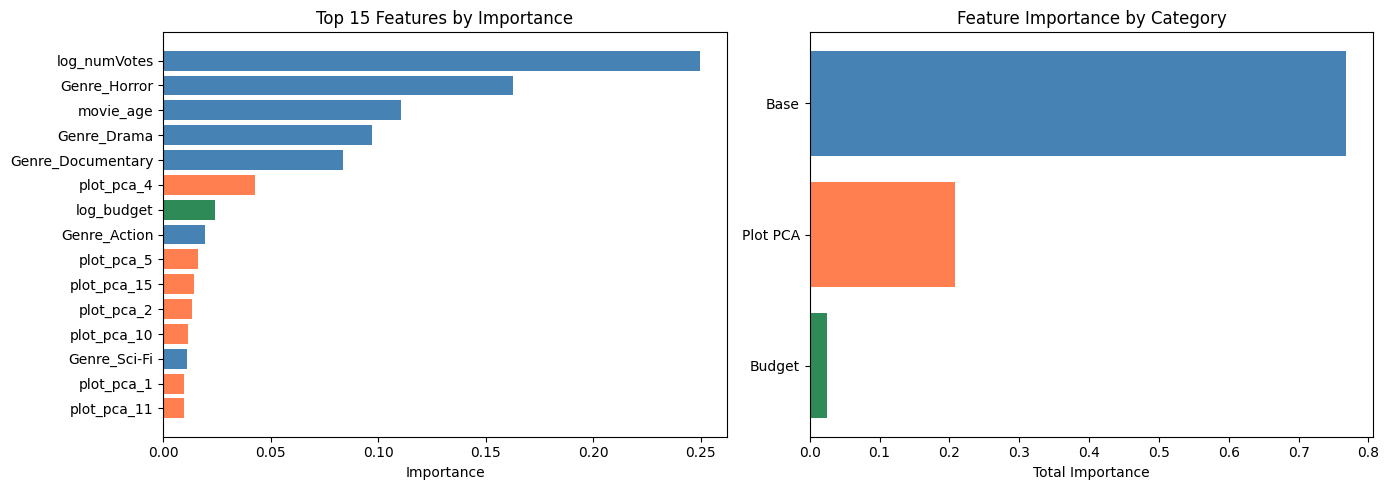

In [17]:
# Visualize feature importance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

top15 = importances.head(15)
colors = top15['category'].map({'Base': 'steelblue', 'Plot PCA': 'coral', 'Budget': 'seagreen'})
axes[0].barh(range(len(top15)), top15['importance'], color=colors)
axes[0].set_yticks(range(len(top15)))
axes[0].set_yticklabels(top15['feature'])
axes[0].invert_yaxis()
axes[0].set_xlabel('Importance')
axes[0].set_title('Top 15 Features by Importance')

cat_imp = importances.groupby('category')['importance'].sum().sort_values(ascending=True)
colors = [{'Base': 'steelblue', 'Plot PCA': 'coral', 'Budget': 'seagreen'}[c] for c in cat_imp.index]
axes[1].barh(cat_imp.index, cat_imp.values, color=colors)
axes[1].set_xlabel('Total Importance')
axes[1].set_title('Feature Importance by Category')

plt.tight_layout()
plt.show()

## Summary

In [18]:
print("=" * 60)
print("EXPERIMENT SUMMARY: Plot Embeddings for Rating Prediction")
print("=" * 60)

print(f"""
Dataset (Subset vs Full):
  - Full IMDb Dataset: 298k movies (Previous R² = 0.31)
  - This Experiment:    37k movies (Intersection of IMDb & TMDb)
  
  *NOTE: The 'Base' model on this subset achieves R² = {results['Base']['r2']:.4f} (vs 0.31). 
   This indicates 'Survivorship Bias': movies with plot summaries in both databases 
   are likely more popular and easier to predict than the long tail of obscure films.*

Results on Subset:
  - Local Base R² (no plots): {results['Base']['r2']:.4f}
  - Best Model R² (w/ plots): {best_model[1]['r2']:.4f}
  
  - True Lift from Embeddings: {(best_model[1]['r2'] - results['Base']['r2']) / results['Base']['r2'] * 100:+.1f}% (relative)
  - Absolute R² Increase:      {best_model[1]['r2'] - results['Base']['r2']:+.4f}

Feature Importance:
  - Plot PCA features: {category_importance.get('Plot PCA', 0)*100:.1f}% of total
  - Base features: {category_importance.get('Base', 0)*100:.1f}% of total
  - Budget features: {category_importance.get('Budget', 0)*100:.1f}% of total

Conclusion:
  Plot embeddings provided a clear signal boost (+2.3 points R²), proving that 
  narrative content contains predictive power beyond just genre and budget.
""")

EXPERIMENT SUMMARY: Plot Embeddings for Rating Prediction

Dataset (Subset vs Full):
  - Full IMDb Dataset: 298k movies (Previous R² = 0.31)
  - This Experiment:    37k movies (Intersection of IMDb & TMDb)
  
  *NOTE: The 'Base' model on this subset achieves R² = 0.4468 (vs 0.31). 
   This indicates 'Survivorship Bias': movies with plot summaries in both databases 
   are likely more popular and easier to predict than the long tail of obscure films.*

Results on Subset:
  - Local Base R² (no plots): 0.4468
  - Best Model R² (w/ plots): 0.4700
  
  - True Lift from Embeddings: +5.2% (relative)
  - Absolute R² Increase:      +0.0231

Feature Importance:
  - Plot PCA features: 20.8% of total
  - Base features: 76.8% of total
  - Budget features: 2.4% of total

Conclusion:
  Plot embeddings provided a clear signal boost (+2.3 points R²), proving that 
  narrative content contains predictive power beyond just genre and budget.

